In [1]:
#!pip install visualkeras
import warnings
warnings.filterwarnings('ignore')

import visualkeras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.1)

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((45000, 32, 32, 3), (45000, 1))
((5000, 32, 32, 3), (5000, 1))
((10000, 32, 32, 3), (10000, 1))


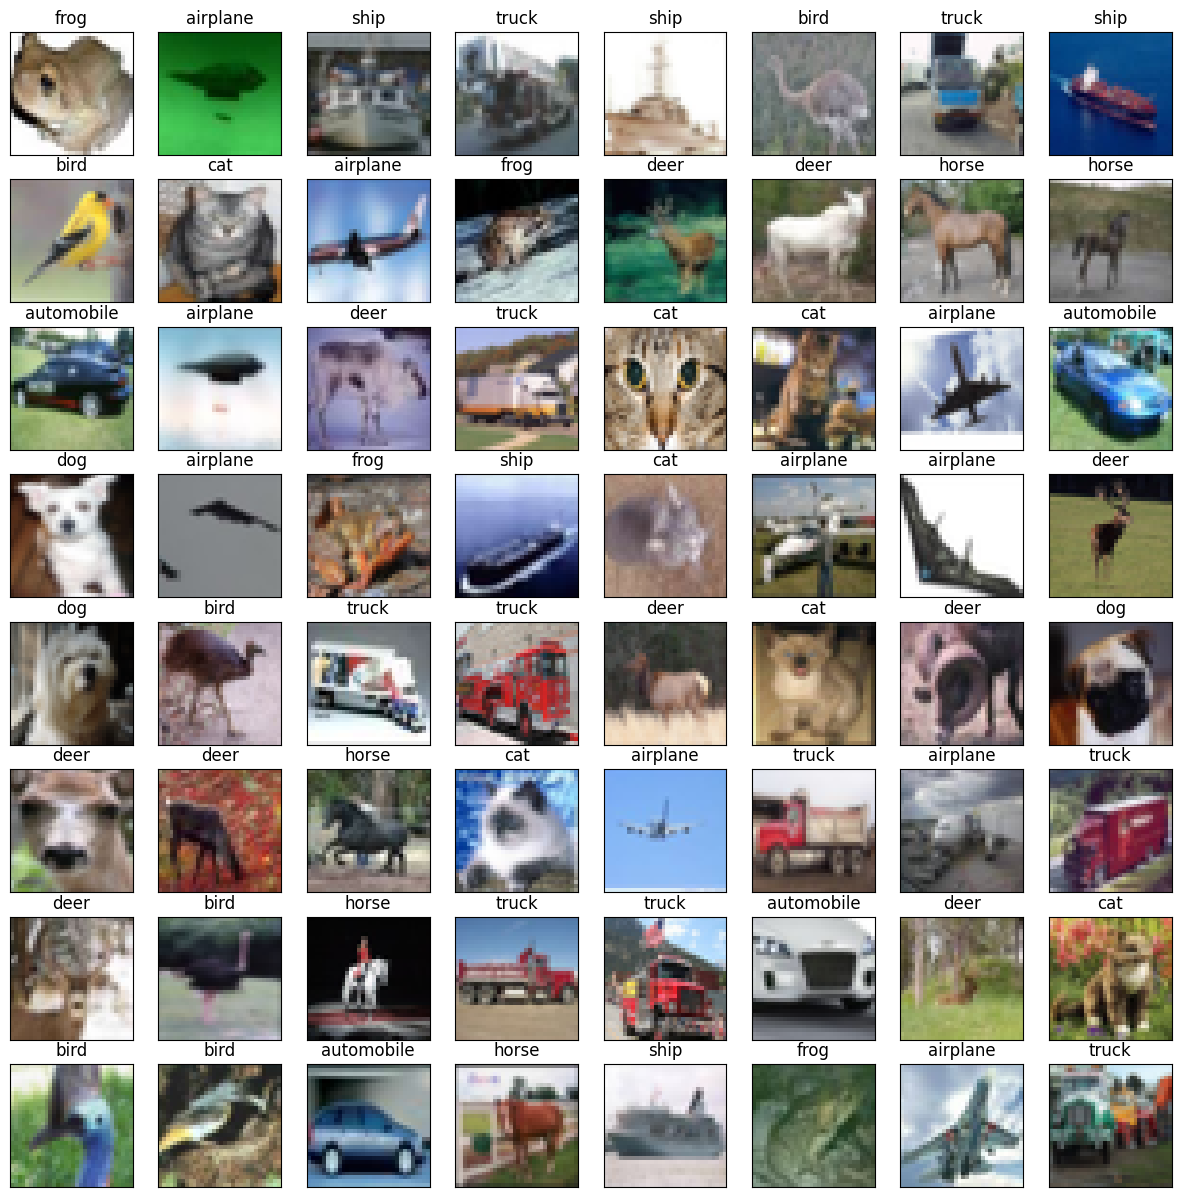

In [3]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(x_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [4]:
#  Augment train set rescale , stretch and translate
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size = 32
)

val_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale = 1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,)

val_generator = train_datagen.flow(
    x_val, y_val,
    batch_size = 32
)

# Only pixel scale on test to avoid overfit
test_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
# Augment test set
test_generator = test_datagen.flow(
    x_test, y_test,
    batch_size = 32
)

In [5]:
# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))


# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

# Dense (fully connected) layers with batch normalization and dropout
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())  # Batch normalization layer
model.add(layers.Dropout(0.5))  # Dropout layer
model.add(layers.Dense(10, activation='softmax'))  # Output layer with 10 classes

# Exponential decay function for the learning rate
initial_learning_rate = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,  # how many steps before the learning rate is updated
    decay_rate=0.96,    # rate at which learning rate decays
    staircase=True      # if True, the learning rate decreases at discrete intervals
)

# Compile the model with suitable loss function and optimizer
optimizer = Adam(learning_rate=lr_schedule)  # Use Adam optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,322 (1.36 MB)

 Trainable params: 357,066 (1.36 MB)

 Non-trainable params: 256 (1.00 KB)

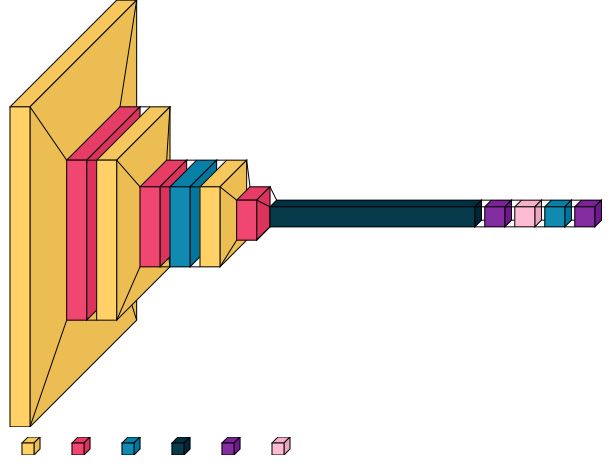

In [11]:
visualkeras.layered_view(model, scale_xy=10, legend=True)

In [6]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the model's validation loss
    patience=5,          # How many epochs to wait after the last time val_loss improved
    restore_best_weights=True  # Restore model weights from the epoch with the best value of val_loss
)

checkpoint = ModelCheckpoint('best.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Fit the CNN model on the training set
history = model.fit(x_train, y_train,
                    epochs=15,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, checkpoint])


# Evaluate the CNN model on the test set
best_model = tf.keras.models.load_model('best.keras')
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3357 - loss: 1.9005
Epoch 1: val_accuracy improved from -inf to 0.44480, saving model to best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3358 - loss: 1.9003 - val_accuracy: 0.4448 - val_loss: 1.5734
Epoch 2/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5152 - loss: 1.3743
Epoch 2: val_accuracy improved from 0.44480 to 0.59300, saving model to best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5152 - loss: 1.3743 - val_accuracy: 0.5930 - val_loss: 1.1591
Epoch 3/15
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5927 - loss: 1.1709
Epoch 3: val_accuracy improved from 0.59300 to 0.66540, saving model to best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5928 - loss: 1.1708 - val_accuracy: 0.6654 - val_loss: 0.9516
Epoch 4/15
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6475 - loss: 1.0340
Epoch 4: val_accuracy improved from 0.66540 

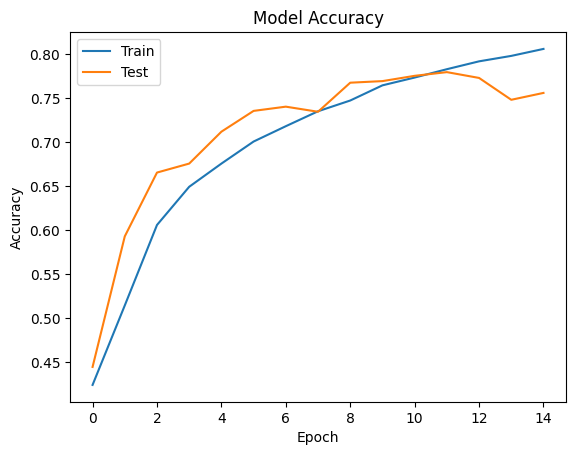

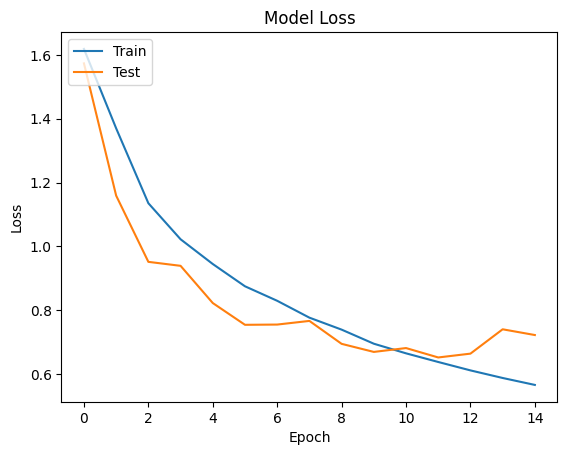

In [7]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


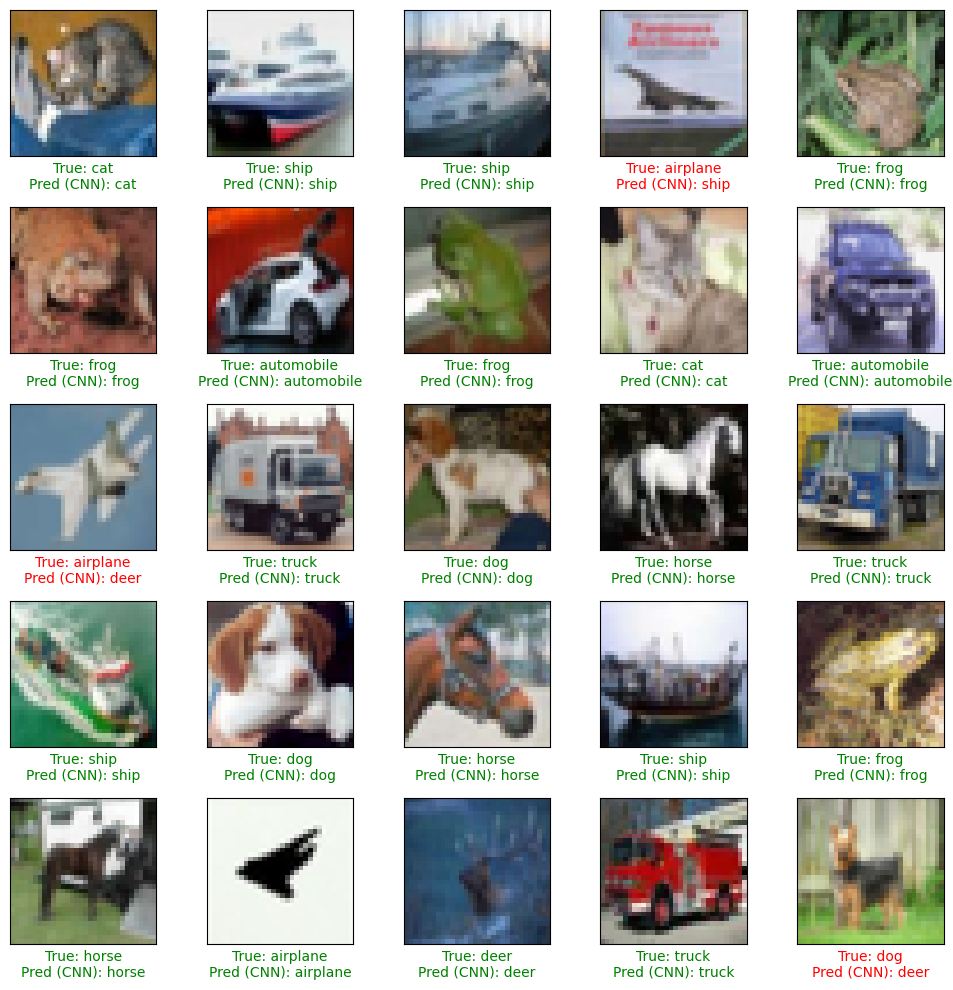

In [8]:
# Get predictions for the test set
predictions_cnn = best_model.predict(x_test)
predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

# Plot sample images with predicted labels
plt.figure(figsize=(10, 10))
for i in range(25):  # Adjust as needed
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])  # Plot original image
    true_label = class_names[y_test[i][0]]  # Get true label
    predicted_label = class_names[predicted_labels_cnn[i]]  # Get predicted label
    if true_label == predicted_label:
        color = 'green'  # Correct prediction
    else:
        color = 'red'  # Incorrect prediction
    plt.xlabel(f"True: {true_label}\nPred (CNN): {predicted_label}", color=color)
plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


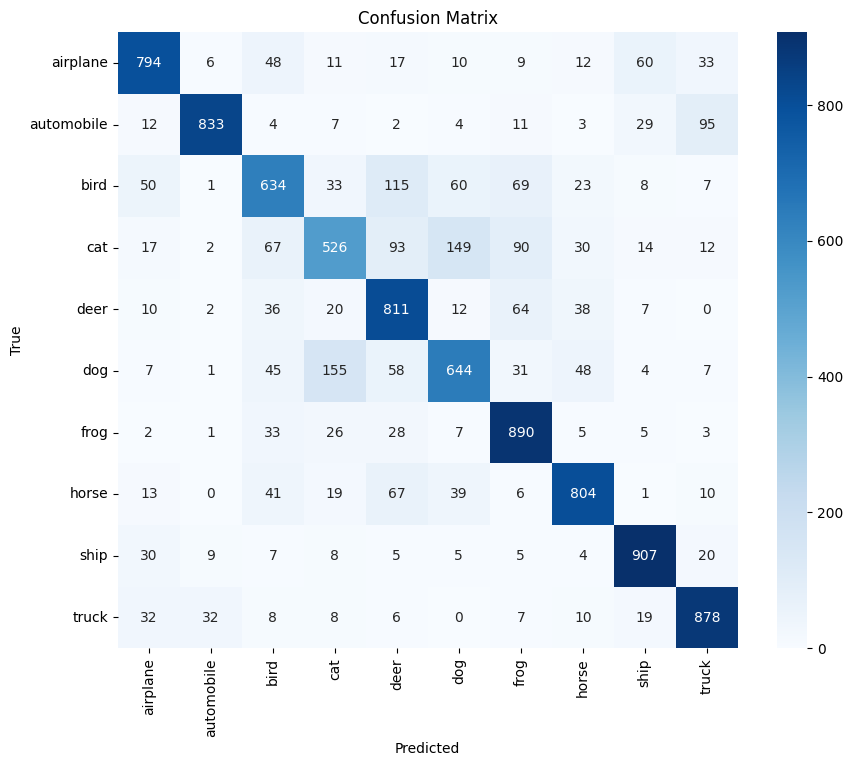

In [17]:
# Get predictions for the test set
predictions_cnn = best_model.predict(x_test)
predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)
true_labels = y_test.flatten()  # Flatten y_test to 1D array

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels_cnn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels_cnn, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.79      0.81      1000
  automobile       0.94      0.83      0.88      1000
        bird       0.69      0.63      0.66      1000
         cat       0.65      0.53      0.58      1000
        deer       0.67      0.81      0.74      1000
         dog       0.69      0.64      0.67      1000
        frog       0.75      0.89      0.82      1000
       horse       0.82      0.80      0.81      1000
        ship       0.86      0.91      0.88      1000
       truck       0.82      0.88      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

